In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
import numpy as np
from matplotlib import pyplot

Using TensorFlow backend.


In [4]:
#https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/


#We could start training this model now with real examples with a class label of
# one and randomly generated samples with a class label of zero
#There is no need to do this, but the elements we will develop will be useful later,
# and it helps to see that the discriminator is just a normal neural network model.
# generate n real samples with class labels
def generate_real_samples(n=100):
    # generate inputs in [-0.5, 0.5]
    X1 = np.random.rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    # generate class labels
    y = np.ones((n, 1))
    return X, y

#The first step is to generate new points in the latent space. We can achieve this by calling the
# randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y


#The generator model takes as input a point from the latent space and generates a new sample,
# e.g. a vector with both the input and output elements of our function, e.g. x and x^2.
#A latent variable is a hidden or unobserved variable, and a latent space is a multi-dimensional
# vector space of these variables. We can define the size of the latent space for our problem
# and the shape or distribution of variables in the latent space.
#This is because the latent space has no meaning until the generator model starts assigning
# meaning to points in the space as it learns. After training, points in the latent space will
# correspond to points in the output space, e.g. in the space of generated samples
#We will generate new inputs by drawing random numbers from a standard Gaussian distribution,
# i.e. mean of zero and a standard deviation of one.
#Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
#Outputs: Two-element vector representing a generated sample for our function (x and x^2).
#The model is not compiled. The reason for this is that the generator model is not fit directly.
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

#The model must take a sample from our problem, such as a vector with two elements, and output a
#classification prediction as to whether the sample is real or fake.
#Inputs: Sample with two real values.
#Outputs: Binary classification, likelihood the sample is real (or fake).
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation="relu", kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

#The weights in the generator model are updated based on the performance of the discriminator model.
#When the discriminator is good at detecting fake samples, the generator is updated more, and
# when the discriminator model is relatively poor or confused when detecting fake samples,
# the generator model is updated less.
#This defines the zero-sum or adversarial relationship between these two models.
#There may be many ways to implement this using the Keras API, but perhaps the simplest
# approach is to create a new model that subsumes or encapsulates the generator and
# discriminator models.
#Specifically, a new GAN model can be defined that stacks the generator and discriminator
# such that the generator receives as input random points in the latent space, generates
# samples that are fed into the discriminator model directly, classified,
# and the output of this larger model can be used to update the model weights of the generator.
#Only the discriminator is concerned with distinguishing between real and fake examples
#The generator model is only concerned with the discriminator’s performance on fake examples.
# Therefore, we will mark all of the layers in the discriminator as not trainable when it is
# part of the GAN model so that they can not be updated and overtrained on fake examples.
#When training the generator via this subsumed GAN model, there is one more important change.
# We want the discriminator to think that the samples output by the generator are real, not fake.
# Therefore, when the generator is trained as part of the GAN model, we will mark the generated
# samples as real (class 1).
#The discriminator model was marked as not trainable, added to the GAN model, and compiled.
# In this model, the model weights of the discriminator model are not trainable and cannot
# be changed when the GAN model is updated via calls to train_on_batch().
#Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
#Outputs: Binary classification, likelihood the sample is real (or fake).
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i + 1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

In [5]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan = define_gan(generator, discriminator)

1999 0.36000001430511475 0.6200000047683716


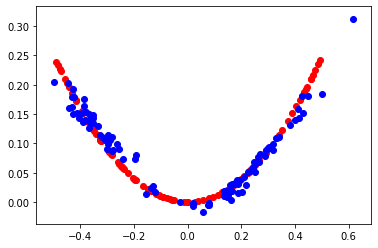

3999 0.5899999737739563 0.47999998927116394


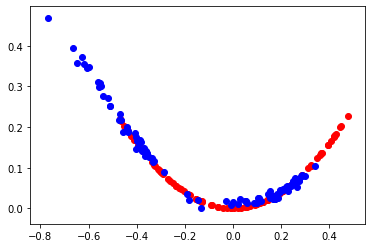

5999 0.5299999713897705 0.05999999865889549


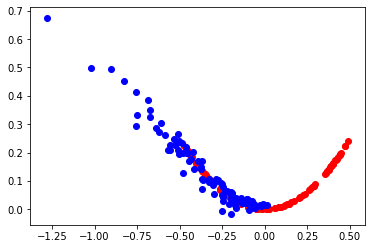

7999 0.5 0.5899999737739563


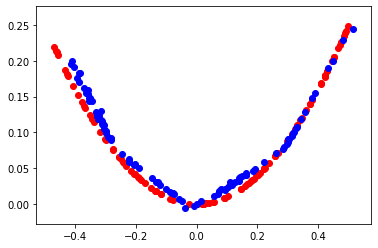

9999 0.4699999988079071 0.6299999952316284


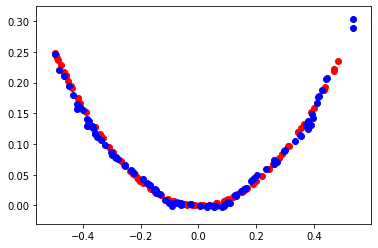

In [6]:
#plot_model(discriminator, to_file="discriminator.png", show_shapes=True)
#plot_model(generator, to_file="generator.png", show_shapes=True)
#plot_model(gan, to_file="gan.png", show_shapes=True)
train(generator, discriminator, gan, latent_dim)